# Practical exercise 8 - Methods 3, 2021.
Aleksander Moeslund Wael

### Importing packages


In [154]:
from matplotlib.colors import Colormap
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150 # HIGH DPI PLOTS PLEASE
import numpy as np

# EXERCISE 1 - Load the magnetoencephalographic recordings and do some initial plots to understand the data

### 1) Load `megmag_data.npy` and call it `data` using `np.load`. You can use `join`, which can be imported from `os.path`, to create paths from different string segments


In [155]:
data = np.load("megmag_data.npy")

i. The data is a 3-dimensional array. The first dimension is number of repetitions of a visual stimulus , the second dimension is the number of sensors that record magnetic fields (in Tesla) that stem from neurons activating in the brain, and the third dimension is the number of time samples. How many repetitions, sensors and time samples are there?

In [156]:
data.shape

(682, 102, 251)

There are 682 repetitions, 102 sensors and 251 time samples.

ii. The time range is from (and including) -200 ms to (and including) 800 ms with a sample recorded every 4 ms. At time 0, the visual stimulus was briefly presented. Create a 1-dimensional array called `times` that represents this.  
    


In [157]:
times = np.arange(-200, 804, 4)

iii. Create the sensor covariance matrix $\Sigma_{XX}$: $$\Sigma_{XX} = \frac 1 N \sum_{i=1}^N XX^T$$ $N$ is the number of repetitions and $X$ has $s$ rows and $t$ columns (sensors and time), thus the shape is $X_{s\times t}$. Do the sensors pick up independent signals? (Use `plt.imshow` to plot the sensor covariance matrix)  


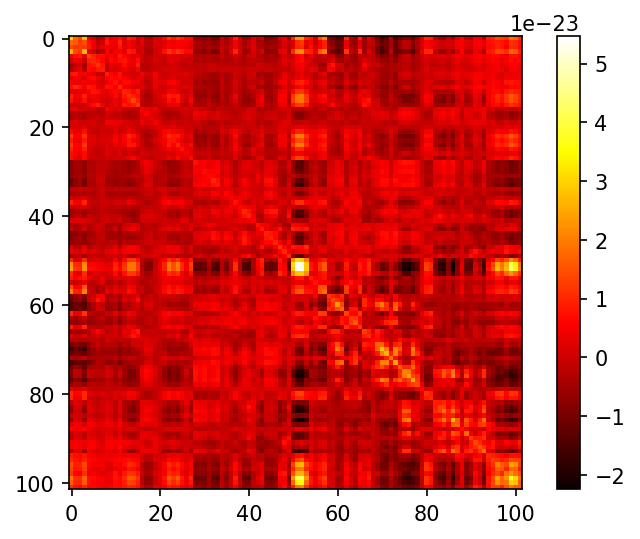

In [158]:
covar = np.zeros(shape = (102,102))

for i in range(682):
    X = data[i]
    covar = covar + X @ np.transpose(X)

covar = (1/682)*covar

plt.close("all")
plt.figure()
plt.imshow(covar, cmap = "hot")
plt.colorbar()
plt.show()

iv. Make an average over the repetition dimension using `np.mean` - use the `axis` argument. (The resulting array should have two dimensions ~~with time as the first and magnetic field as the second~~ with sensor as the first and time as the second)  


In [159]:
datamean = data.mean(axis=0)
datamean.shape

(102, 251)

v. Plot the magnetic field (based on the average) as it evolves over time for each of the sensors (a line for each) (time on the x-axis and magnetic field on the y-axis). Add a horizontal line at $y = 0$ and a vertical line at $x = 0$ using `plt.axvline` and `plt.axhline`  


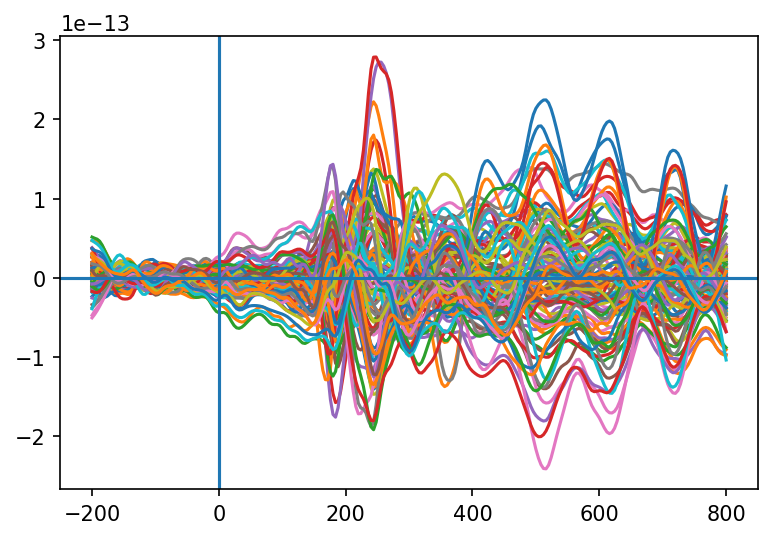

In [160]:
plt.close("all")
plt.figure()
plt.plot(times, datamean.T)
plt.axvline()
plt.axhline()
plt.show()

vi. Find the maximal magnetic field in the average. Then use `np.argmax` and `np.unravel_index` to find the sensor that has the maximal magnetic field.  


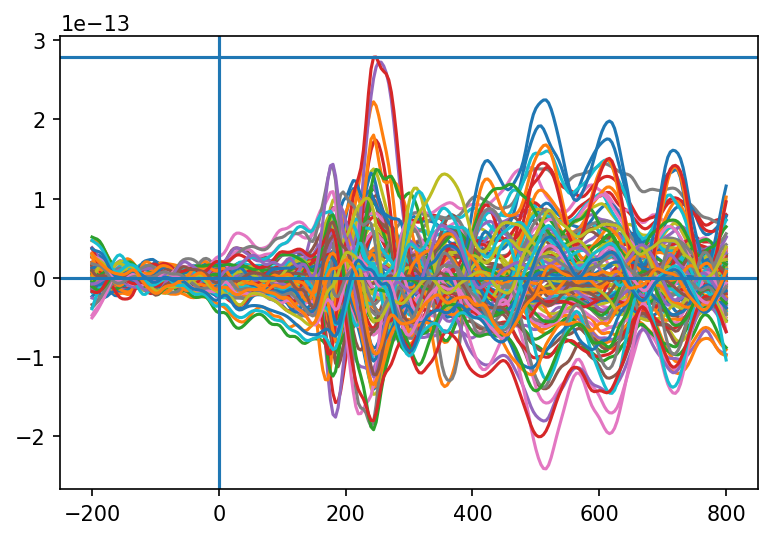

18435
(73, 112)


In [161]:
sensor_max = np.amax(datamean)

plt.close("all")
plt.figure()
plt.plot(times, datamean.T)
plt.axvline()
plt.axhline()
plt.axhline(np.amax(datamean))
plt.show()

np.argmax(datamean) # finding the index (think: coordinates) for the biggest value
print(np.argmax(datamean))

a = np.unravel_index(np.argmax(datamean), shape = (102, 251)) # shape = the space where it searches for the index
print(a) # The sensor with max magnetic value is no. 73

 vii. Plot the magnetic field for each of the repetitions (a line for each) for the sensor that has the maximal magnetic field. Highlight the time point with the maximal magnetic field in the average (as found in 1.1.v) using `plt.axvline`  


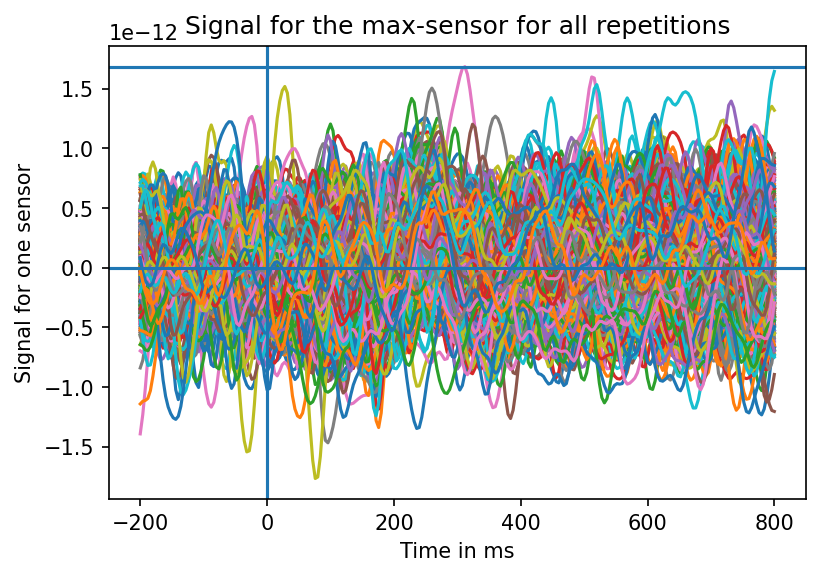

In [162]:
plt.figure() 
plt.plot(times, data[:,73,:].T)
plt.axhline(np.amax(data[:,73,:].T))
plt.axvline(x = 0)
plt.axhline(y = 0)
plt.xlabel("Time in ms")
plt.ylabel("Signal for one sensor")
plt.title("Signal for the max-sensor for all repetitions")
plt.show()

viii. Describe in your own words how the response found in the average is represented in the single repetitions. But do make sure to use the concepts _signal_ and _noise_ and comment on any differences on the range of values on the y-axis  

EXPLAIN


### 2) Now load `pas_vector.npy` (call it `y`). PAS is the same as in Assignment 2, describing the clarity of the subjective experience the subject reported after seeing the briefly presented stimulus


In [163]:
y = np.load("pas_vector.npy")

i. Which dimension in the `data` array does it have the same length as?  


It has the same length as repetitions, because there is a PAS rating per repitition.

ii. Now make four averages (As in Exercise 1.1.iii), one for each PAS rating, and plot the four time courses (one for each PAS rating) for the sensor found in Exercise ~~1.1.v~~  1.1.vi


<function matplotlib.pyplot.show(close=None, block=None)>

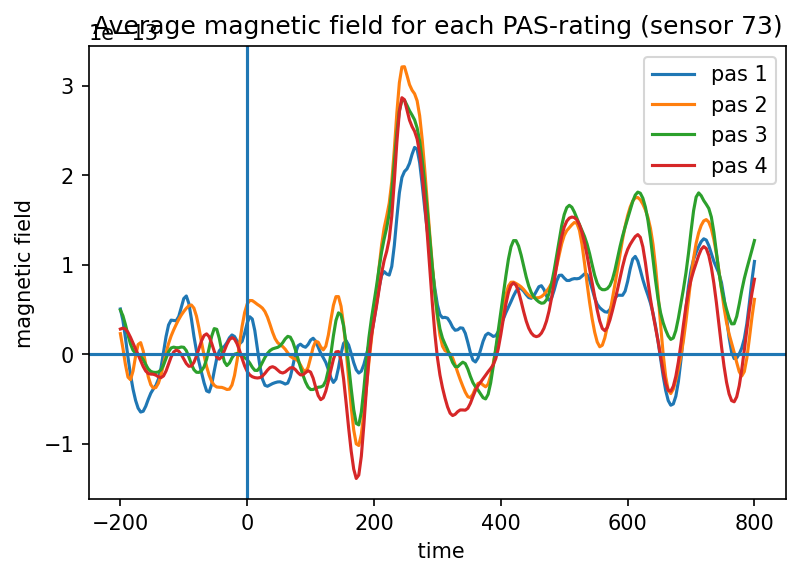

In [164]:
# subsetting the data, so I'm only looking at sensor 73 
data_73 = data[:, 73, :]

# in y I find the indices for each different pas rating and assign them to new lists
pas_1 = np.where(y == 1)
pas_2 = np.where(y == 2)
pas_3 = np.where(y == 3)
pas_4 = np.where(y == 4)

# finding the average brain activation in sensor 73 seperated by pas-rating
sens_73_pas1_avg = np.mean(data_73[pas_1], axis = 0)
sens_73_pas2_avg = np.mean(data_73[pas_2], axis = 0)
sens_73_pas3_avg = np.mean(data_73[pas_3], axis = 0)
sens_73_pas4_avg = np.mean(data_73[pas_4], axis = 0)

# plotting this baby
plt.figure
plt.plot(times, sens_73_pas1_avg)
plt.plot(times, sens_73_pas2_avg)
plt.plot(times, sens_73_pas3_avg)
plt.plot(times, sens_73_pas4_avg)
plt.axvline()
plt.axhline()
plt.xlabel(" time")
plt.ylabel("magnetic field")
plt.title("Average magnetic field for each PAS-rating (sensor 73)")
plt.legend(["pas 1", "pas 2", "pas 3", "pas 4"])
plt.show

iii. Notice that there are two early peaks (measuring visual activity from the brain), one before 200 ms and one around 250 ms. Describe how the amplitudes of responses are related to the four PAS-scores. Does PAS 2 behave differently than expected?  

EXPLAIN

# EXERCISE 2 - Do logistic regression to classify pairs of PAS-ratings

### 1) Now, we are going to do Logistic Regression with the aim of classifying the PAS-rating given by the subject

i. We'll start with a binary problem - create a new array called `data_1_2` that only contains PAS responses 1 and 2. Similarly, create a `y_1_2` for the target vector

In [165]:
data_1_2 = np.concatenate((data[pas_1], data[pas_2]), axis=0)
data_1_2.shape

y_1_2 = []
for i in range(len(y)):
    if y[i] == 1:
        y_1_2.append(1)
    if y[i] == 2:
        y_1_2.append(2)

ii. Scikit-learn expects our observations (`data_1_2`) to be in a 2d-array, which has samples (repetitions) on dimension 1 and features (predictor variables) on dimension 2. Our `data_1_2` is a three-dimensional array. Our strategy will be to collapse our two last dimensions (sensors and time) into one dimension, while keeping the first dimension as it is (repetitions). Use `np.reshape` to create a variable `X_1_2` that fulfils these criteria.

In [166]:
# repetition as rows, and sensor and time as columns
X_1_2 = data_1_2.reshape(214, -1)
X_1_2.shape

(214, 25602)

iii. Import the `StandardScaler` and scale `X_1_2`  


In [167]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_1_2_scaled = sc.fit_transform(X_1_2)

iv. Do a standard `LogisticRegression` - can be imported from `sklearn.linear_model` - make sure there is no `penalty` applied

In [168]:
from sklearn.linear_model import LogisticRegression

logR = LogisticRegression(penalty='none') # no regularisation

logR.fit(X_1_2_scaled, y_1_2)

LogisticRegression(penalty='none')

v. Use the `score` method of `LogisticRegression` to find out how many labels were classified correctly. Are we overfitting? Besides the score, what would make you suspect that we are overfitting?  

In [169]:
print(logR.score(X_1_2_scaled, y_1_2))

1.0


vi. Now apply the _L1_ penalty instead - how many of the coefficients (`.coef_`) are non-zero after this?  

In [170]:
logR = LogisticRegression(penalty="l1", solver='liblinear', random_state=1) # With regularization
logR.fit(X_1_2_scaled, y_1_2)
print(logR.score(X_1_2_scaled, y_1_2))

fit1 = logR.fit(X_1_2_scaled, y_1_2)

print(np.sum(fit1.coef_ == 0))
print(np.sum(fit1.coef_ != 0)) # = 217 coefs were nonzero

1.0
25385
217


vii. Create a new reduced $X$ that only includes the non-zero coefficients - show the covariance of the non-zero features (two covariance matrices can be made; $X_{reduced}X_{reduced}^T$ or $X_{reduced}^TX_{reduced}$ (you choose the right one)) . Plot the covariance of the features using `plt.imshow`. Compared to the plot from 1.1.iii, do we see less covariance?

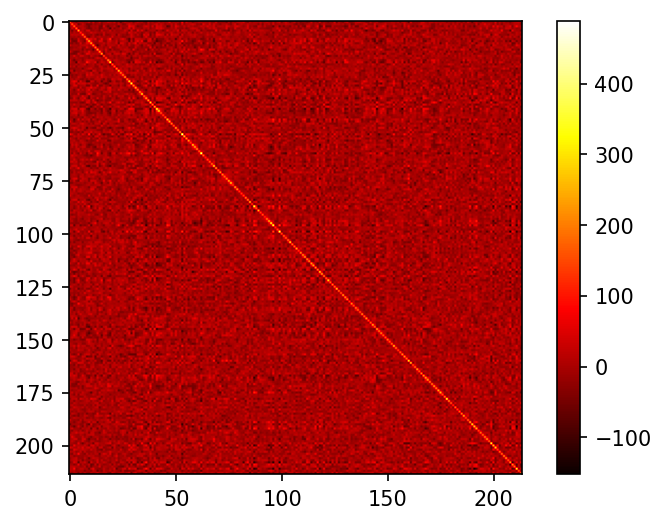

In [171]:
coefs = logR.coef_.flatten()
non_zero = coefs != 0
X_reduced = X_1_2_scaled[:, non_zero]

# Non-zero coefficients covariance matrix
coef_covar = X_reduced @ np.transpose(X_reduced)

plt.close("all")
plt.figure()
plt.imshow(coef_covar, cmap = "hot")
plt.colorbar()
plt.show()

In [172]:
X_reduced.shape

(214, 217)

### 2) Now, we are going to build better (more predictive) models by using cross-validation as an outcome measure

i. Import `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection`

In [173]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

ii. To make sure that our training data sets are not biased to one target (PAS) or the other, create `y_1_2_equal`, which should have an equal number of each target. Create a similar `X_1_2_equal`. The function `equalize_targets_binary` in the code chunk associated with Exercise 2.2.ii can be used. Remember to scale `X_1_2_equal`!

In [174]:
def equalize_targets_binary(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) > 2:
        raise NameError("can't have more than two targets")
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count,replace=False)
    
    # create the new data sets
    new_indices = np.concatenate((first_choice, second_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

# Making equal data with function
y_1_2 = np.array(y_1_2) # Has to be array instead of list, thats why
data_1_2_equal, y_1_2_equal = equalize_targets_binary(data_1_2, y_1_2) # Assigning new data
X_1_2_equal = data_1_2_equal.reshape(198, -1)
X_1_2_equal = sc.fit_transform(X_1_2_equal)

iii. Do cross-validation with 5 stratified folds doing standard `LogisticRegression` (See Exercise 2.1.iv)

In [175]:
cv = StratifiedKFold()

logR = LogisticRegression()
logR.fit(X_1_2_equal, y_1_2_equal)

scores = cross_val_score(logR, X_1_2_equal, y_1_2_equal, cv=5)
print(np.mean(scores))

0.4694871794871795


iv. Do L2-regularisation with the following `Cs=  [1e5, 1e1, 1e-5]`. Use the same kind of cross-validation as in Exercise 2.2.iii. In the best-scoring of these models, how many more/fewer predictions are correct (on average)?

In [176]:
# With C = 1e5
cv = StratifiedKFold()

logR = LogisticRegression(C=1e5, penalty="l2")
logR.fit(X_1_2_equal, y_1_2_equal)

scores = cross_val_score(logR, X_1_2_equal, y_1_2_equal, cv=5)
print(np.mean(scores))

# With C = 1e1
cv = StratifiedKFold()

logR = LogisticRegression(C=1e1, penalty="l2")
logR.fit(X_1_2_equal, y_1_2_equal)

scores = cross_val_score(logR, X_1_2_equal, y_1_2_equal, cv=5)
print(np.mean(scores))

# With C = 1e-1
cv = StratifiedKFold()

logR = LogisticRegression(C=1e-5, penalty="l2")
logR.fit(X_1_2_equal, y_1_2_equal)

logR.predict

scores = cross_val_score(logR, X_1_2_equal, y_1_2_equal, cv=5)
print(np.mean(scores))

0.4746153846153846
0.4746153846153846
0.45487179487179485


v. Instead of fitting a model on all `n_sensors * n_samples` features, fit  a logistic regression (same kind as in Exercise 2.2.iv (use the `C` that resulted in the best prediction)) for __each__ time sample and use the same cross-validation as in Exercise 2.2.iii. What are the time points where classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)

In [177]:
# I need 251 models.
cv = StratifiedKFold()
logR = LogisticRegression(C=1e1, penalty="l2", solver = "liblinear")
cv_scores = []

# Subsetting time
for i in range(251):
    t = sc.fit_transform(data_1_2_equal[:,:,i])
    logR.fit(t, y_1_2_equal)
    scores = cross_val_score(logR, t, y_1_2_equal, cv=5)
    cv_scores.append(np.mean(scores))

In [178]:
# Picking highest score
print(np.amax(cv_scores))
print(np.argmax(cv_scores)) # Indeci with highest classification

0.611025641025641
94


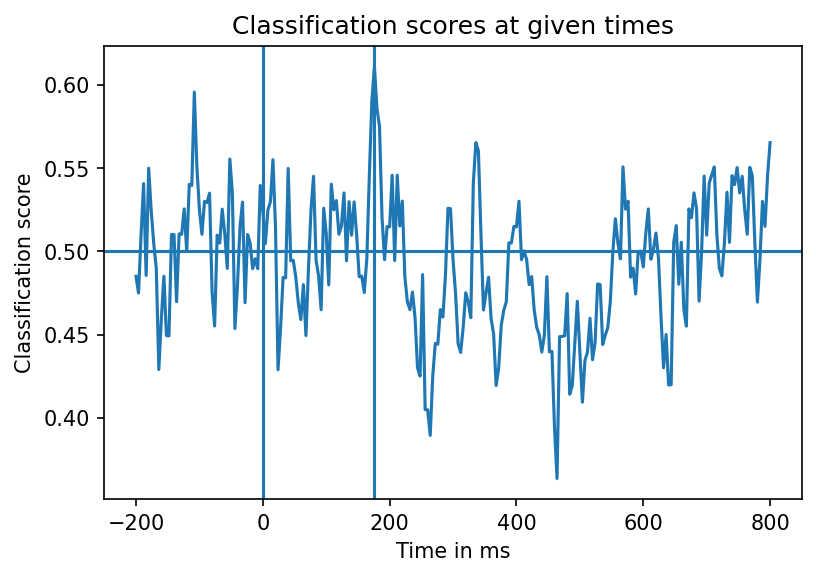

176

In [179]:
plt.figure() 
plt.plot(times, cv_scores)
plt.axvline(x = 0)
plt.axvline(times[94])
plt.axhline(y = 0.5) # Chance level is 50% for binary classification
plt.xlabel("Time in ms")
plt.ylabel("Classification score")
plt.title("Classification scores at given times")
plt.show()

times[94]

# Classification is best at 176 ms.

vi. Now do the same, but with L1 regression - set `C=1e-1` - what are the time points when classification is best? (make a plot)?

In [180]:
cv = StratifiedKFold()
logR = LogisticRegression(C=1e-1, penalty="l1", solver = "liblinear")
cv_scores = []

# Subsetting time
for i in range(251):
    t = sc.fit_transform(data_1_2_equal[:,:,i])
    logR.fit(t, y_1_2_equal)
    scores = cross_val_score(logR, t, y_1_2_equal, cv=5)
    cv_scores.append(np.mean(scores))


In [181]:
# Picking highest score
print(np.amax(cv_scores))
print(np.argmax(cv_scores)) # Indeci with highest classification

0.6111538461538462
36


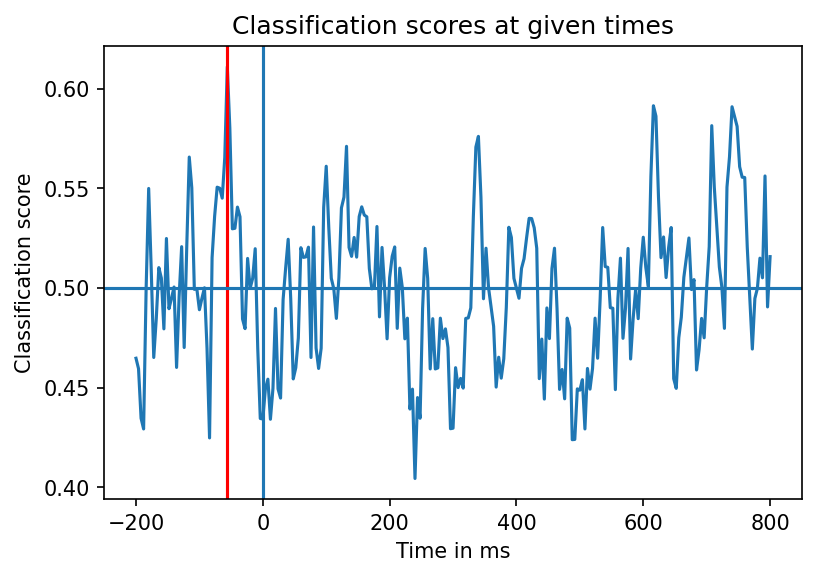

-56

In [182]:
plt.figure() 
plt.plot(times, cv_scores)
plt.axvline(x = 0)
plt.axvline(times[36], color = "red")
plt.axhline(y = 0.5) # Chance level is 50% for binary classification
plt.xlabel("Time in ms")
plt.ylabel("Classification score")
plt.title("Classification scores at given times")
plt.show()

times[36]

# Classification is best at -56 ms.

vii. Finally, fit the same models as in Exercise 2.2.vi but now for `data_1_4` and `y_1_4` (create a data set and a target vector that only contains PAS responses 1 and 4). What are the time points when classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)

In [183]:
# Prepare array
data_1_4 = np.concatenate((data[pas_1], data[pas_4]), axis=0)
data_1_4.shape

(359, 102, 251)

In [184]:
# Prepare target vector
y_1_4 = []
for i in range(len(y)):
    if y[i] == 1:
        y_1_4.append(1)
    if y[i] == 4:
        y_1_4.append(4)

# repetition as rows, and sensor and time as columns
X_1_4 = data_1_4.reshape(359, -1)
X_1_4.shape

(359, 25602)

In [185]:
# Scaling data
X_1_4_scaled = sc.fit_transform(X_1_4)

In [186]:
# Making equal data with function
y_1_4 = np.array(y_1_4) # Has to be array instead of list, thats why
data_1_4_equal, y_1_4_equal = equalize_targets_binary(data_1_4, y_1_4) # Assigning new data
X_1_4_equal = data_1_4_equal.reshape(198, -1)
X_1_4_equal = sc.fit_transform(X_1_4_equal)

In [187]:
cv = StratifiedKFold()
logR = LogisticRegression(C=1e-1, penalty="l1", solver = "liblinear")
cv_scores_1_4 = []

# Subsetting time
for i in range(251):
    t = sc.fit_transform(data_1_4_equal[:,:,i])
    logR.fit(t, y_1_4_equal)
    scores = cross_val_score(logR, t, y_1_4_equal, cv=5)
    cv_scores_1_4.append(np.mean(scores))

In [188]:
# Picking highest score
print(np.amax(cv_scores_1_4))
print(np.argmax(cv_scores_1_4)) # Indeci with highest classification

0.5857692307692307
118


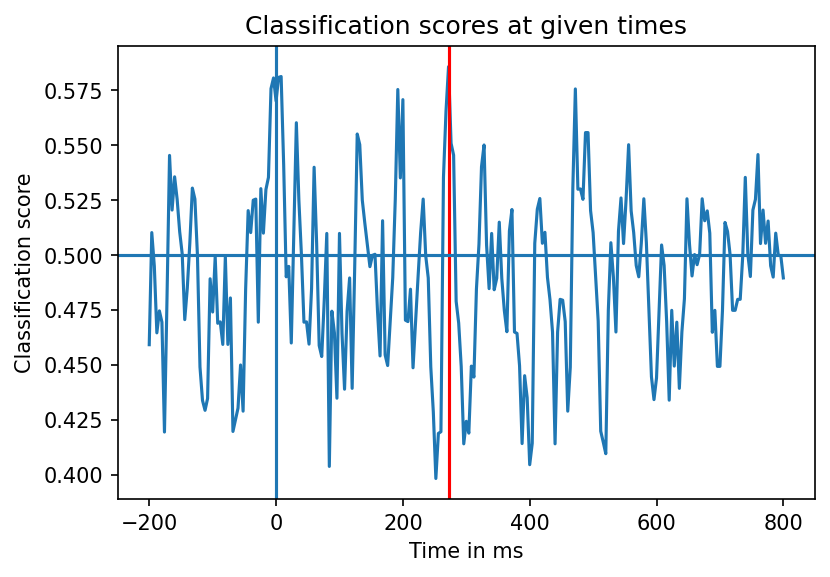

272

In [189]:
# Plotting
plt.figure() 
plt.plot(times, cv_scores_1_4)
plt.axvline(x = 0)
plt.axvline(times[118], color = "red")
plt.axhline(y = 0.5) # Chance level is 50% for binary classification
plt.xlabel("Time in ms")
plt.ylabel("Classification score")
plt.title("Classification scores at given times")
plt.show()

times[118]

# Classification is best at 272 ms.

### 3) Is pairwise classification of subjective experience possible? Any surprises in the classification accuracies, i.e. how does the classification score fore PAS 1 vs 4 compare to the classification score for PAS 1 vs 2?  

EXPLAIN

# EXERCISE 3 - Do a Support Vector Machine Classification on all four PAS-ratings  

### 1) Do a Support Vector Machine Classification

i. First equalize the number of targets using the function associated with each PAS-rating using the function associated with Exercise 3.1.i

In [190]:
# Define function
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y)
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target))
        indices.append(np.where(y == target)[0])
    min_count = np.min(counts)
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count, replace=False)
    third_choice = np.random.choice(indices[2], size=min_count, replace=False)
    fourth_choice = np.random.choice(indices[3], size=min_count, replace=False)
    
    new_indices = np.concatenate((first_choice, second_choice,
                                 third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

In [191]:
# Making data equal
data_equal, y_equal = equalize_targets(data, y)
print(data_equal.shape)
print(y_equal.shape)

(396, 102, 251)
(396,)


ii. Run two classifiers, one with a linear kernel and one with a radial basis (other options should be left at their defaults) - the number of features is the number of sensors multiplied the number of samples. Which one is better predicting the category?

In [192]:
# Import
from sklearn.svm import SVC

# Making classes
svm_linear = SVC(kernel="linear")
svm_radial = SVC(kernel="rbf")

# Converting to 2d array
X_equal = data_equal.reshape(396, -1)
print(X_equal.shape)

# Scaling data
X_equal_scaled = sc.fit_transform(X_equal)

# Fitting
scores_svm_linear = cross_val_score(svm_linear, X_equal_scaled, y_equal, cv=cv)
print("The linear basis classifier score is", np.mean(scores_svm_linear))

# Fitting
scores_svm_radial = cross_val_score(svm_radial, X_equal_scaled, y_equal, cv=cv)
print("The radial basis classifier score is", np.mean(scores_svm_radial))

(396, 25602)
The linear basis classifier score is 0.2928164556962025
The radial basis classifier score is 0.3333544303797468


In [193]:
# It appears that the radial classifier is best with mean scores of 0,34. Though chance level is at 0,25, so this is a pretty bad performance.

iii. Run the sample-by-sample analysis (similar to Exercise 2.2.v) with the best kernel (from Exercise 3.1.ii). Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)

In [194]:
# I need 251 models.
cv = StratifiedKFold()
svm_radial = SVC(kernel="rbf")
cv_scores_svm = []

# Subsetting time
for i in range(251):
    t = sc.fit_transform(data_equal[:,:,i])
    logR.fit(t, y_equal)
    scores = cross_val_score(svm_radial, t, y_equal, cv=5)
    cv_scores_svm.append(np.mean(scores))

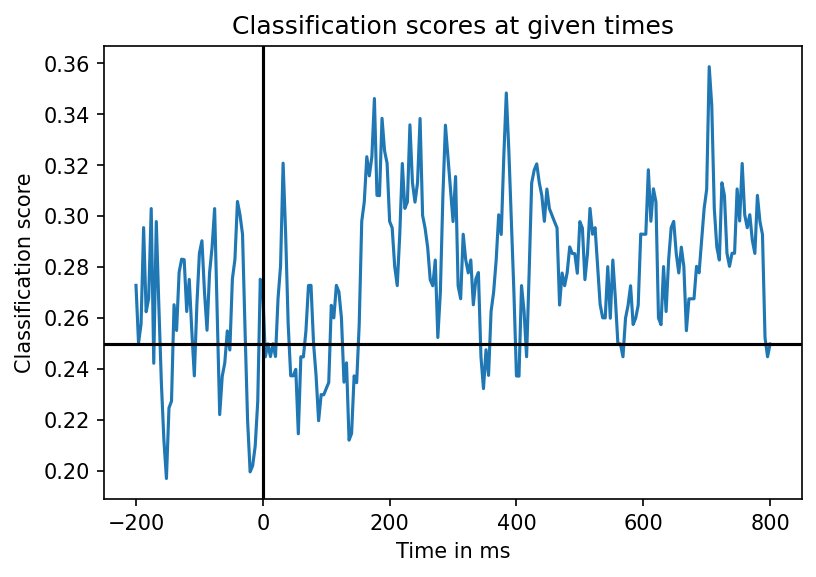

In [195]:
# Plotting
plt.figure() 
plt.plot(times, cv_scores_svm)
plt.axvline(x = 0, color = "black")
plt.axhline(y = 0.25, color = "black") # Chance level is 25% for classification with 4 classes
plt.xlabel("Time in ms")
plt.ylabel("Classification score")
plt.title("Classification scores at given times")
plt.show()

iv. Is classification of subjective experience possible at around 200-250 ms?

- It is better than chance level at this time, with classification scores around 0.30-0.34.

### 2) Finally, split the equalized data set (with all four ratings) into a training part and test part, where the test part if 30 % of the trials. Use `train_test_split` from `sklearn.model_selection`

In [196]:
# Import
from sklearn.model_selection import train_test_split

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_equal, y_equal, test_size=0.30)

i. Use the kernel that resulted in the best classification in Exercise 3.1.ii and `fit` the training set and `predict` on the test set. This time your features are the number of sensors multiplied by the number of samples.

In [197]:
# Setting up class
svm_radial = SVC(kernel="rbf")

# Fitting
svm_radial.fit(X_train, y_train)

# Predicting
predictions = svm_radial.predict(X_test)
print(predictions)

[2 4 4 1 4 1 4 4 4 4 1 3 4 4 2 1 2 4 1 4 4 4 1 2 4 4 4 1 4 1 1 2 1 1 3 4 4
 2 4 1 1 2 1 4 4 1 2 2 4 4 1 4 1 3 1 3 4 1 4 4 4 1 4 1 1 3 1 4 1 1 1 2 4 4
 4 4 4 4 3 4 1 1 4 4 3 1 4 1 1 1 4 1 2 4 1 4 4 1 4 4 3 1 1 4 4 4 1 2 3 4 4
 1 4 3 4 4 2 1 4]


ii. Create a _confusion matrix_. It is a 4x4 matrix. The row names and the column names are the PAS-scores. There will thus be 16 entries. The PAS1xPAS1 entry will be the number of actual PAS1, $y_{pas1}$ that were predicted as PAS1, $\hat y_{pas1}$. The PAS1xPAS2 entry will be the number of actual PAS1, $y_{pas1}$ that were predicted as PAS2, $\hat y_{pas2}$ and so on for the remaining 14 entries.  Plot the matrix

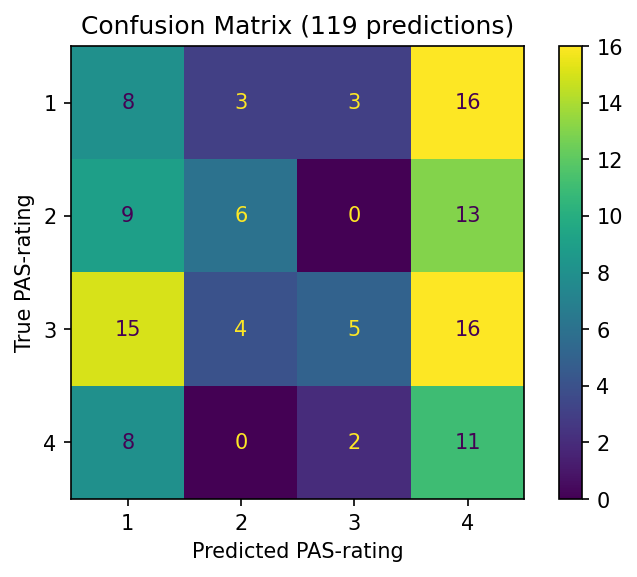

In [198]:
# Import
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay as cmd

# Plot
plt.close("all")
cmd.from_estimator(svm_radial, X_test, y_test) # Plotting given estimator, test data and true labels.
plt.xlabel("Predicted PAS-rating")
plt.ylabel("True PAS-rating")
plt.title("Confusion Matrix (119 predictions)")
plt.show()

iii. Based on the confusion matrix, describe how ratings are misclassified and if that makes sense given that ratings should measure the strength/quality of the subjective experience. Is the classifier biased towards specific ratings?

- 